In [1]:
from re import L
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import torch
import os
from models.custom_models import custom_models
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
import scipy
import pickle
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import argparse
from sklearn.mixture import GaussianMixture
from CIRF_modules import trainer
from CIRF_modules import finder
import pickle
from tqdm import tqdm
import PIL
import torch.backends.cudnn as cudnn
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = argparse.Namespace(
        path = 'mnist_incorrect_75mode_1108',
        peak_ratio = 0.2, # confidence of label in latent codes
        normal_method = 'mode',
        mode_ratio = 1.0,
        sub_weight = 0.02,
        GMM_component = 5,
        seed = 2,
        device = 0,
        multi_gpu = True,
        w_shift = True,
        k_count = 25, # the number of directions
        shift_distribution_key = 'normal', # distribution of eps
        lr = 1e-2, 
        elastic_coef = 1e-2,
        batch_size = 3, # training batch
        min_shift = 0.0001, # minumum magnitude of eps
        shift_scale = 5.0, # magnitude of eps
        label_weight = 1.0, # coef of loss function
        shift_weight = 0.25, # coef of loss function
        n_latent = 14, # w dim
        eps_distribution = 'none', # distribution of eps
        latent_dim = 100, # generator's latent
        num_steps = 300, # training steps
        num_classes = 10, # the number of classes
        save_path = './models/pretrain/test/',
        input_latent_path = './data/latent_g_input_saved/incorrect_latent_torch/',
        latent_iteration = 300, # the number of generating random latent
        random_latent_std = 1, # std of random latent
        latent_batch = 50, # the number of generating random latent batch
        latent_type = 'random', # 'random' or 'training' : type of latent codes
        classifier_path = './models/pretrain/mnist_classifier.pt', # classifier path
        embedder_path = './models/pretrain/celebA_hair5_w_compete_normal.pt', # projector(embedder) path
        tensorboard_path = './results/celebA/tb_results_hair5_gmmcenter_w_normal',
        w_traindata_path = './data/mnist/refined_latent_dict.pth',
        modifying_trial = 15,
        top_center = False,
        tuned_gamma = True,
        use_transform = False,
        use_calibration = False,
        use_perturbing = True,
        w_space = False,
        class_range = None,
        incorrect = True,
    )
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)
debug_mode = True


In [3]:

# model load

classifier = custom_models.CNN().to(device)
generator = custom_models.Generator().to(device)
classifier_state_dict = torch.load(args.classifier_path)
generator_state_dict = torch.load('./models/pretrain/mnist_generator.pt')
classifier.load_state_dict(classifier_state_dict)
generator.load_state_dict(generator_state_dict)

classifier = classifier.to(device)
generator = generator.to(device)

classifier.eval()
generator.eval()

transform = transforms.Compose([
                                # transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                                ]
                               )

def mnist_transform(input_tensor):
    return input_tensor / 255 * 2 - 1


def invTrans(image):
    return image * 0.5 + 0.5


tensor_to_pil_transform = transforms.Compose([
                                transforms.ToPILImage()
])


In [4]:
# data load

file_list = os.listdir('./data/mnist/latent_g_input_saved/incorrect_latent_torch/')
file_list.sort()
jpg_list = []
torch_list = []
tensor_list = []

for name in file_list:
    if 'jpg' in name:
        jpg_list.append(name)
    elif 'pt' in name:
        torch_list.append(name)
    elif 'torch' in name:
        tensor_list.append(name)

number_list = len(torch_list)
incorrect_list = number_list
sample = torch.load('./data/mnist/latent_g_input_saved/incorrect_latent_torch/' + torch_list[0])
auged_data_incorrect = torch.zeros((torch.zeros(number_list).shape + sample.shape)).to(device)

sample = plt.imread('./data/mnist/latent_g_input_saved/incorrect_latent_torch/' + jpg_list[0])
original_image_incorrect = torch.zeros((torch.zeros(number_list).shape + (1, 28, 28)), dtype=torch.float).to(device)
generated_image_incorrect = torch.zeros((torch.zeros(number_list).shape + (1, 28, 28)), dtype=torch.float).to(device)
original_tensor_incorrect = torch.zeros((torch.zeros(number_list).shape + (1, 28, 28)), dtype=torch.float).to(device)
generated_tensor_incorrect = torch.zeros((torch.zeros(number_list).shape + (1, 28, 28)), dtype=torch.float).to(device)


for i, name in enumerate(jpg_list):
    temp_name = name.replace('jpg', 'pt')
    loaded_data = torch.load('./data/mnist/latent_g_input_saved/incorrect_latent_torch/' + temp_name)
    auged_data_incorrect[i] = loaded_data.to(device)
    loaded_image = plt.imread('./data/mnist/latent_g_input_saved/incorrect_latent_torch/' + name)
    loaded_image_original = loaded_image[:, :28, 0].reshape(1, 28, 28)
    loaded_image_generated = loaded_image[:, 28:, 0].reshape(1, 28, 28)
    loaded_image_original = torch.tensor(loaded_image_original)
    loaded_image_generated = torch.tensor(loaded_image_generated)
    original_image_incorrect[i] = loaded_image_original
    generated_image_incorrect[i] = loaded_image_generated


counterclass_np = torch.load('./data/mnist/latent_g_input_saved/incorrect_latent/real_label')

sample_z = auged_data_incorrect.squeeze()


In [5]:
# CIRF module load
trainer = trainer.FinderTrainer(classifier, generator, args, tuned_gamma=args.tuned_gamma, use_transform=args.use_transform)
torch.save(trainer.refined_latent_dict, args.w_traindata_path)

latent generating:   0%|          | 0/300 [00:00<?, ?it/s]

center of target maker: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [6]:
iteration = 0
loaded_sample_images = mnist_transform(generated_image_incorrect)
save_distances = pd.DataFrame()

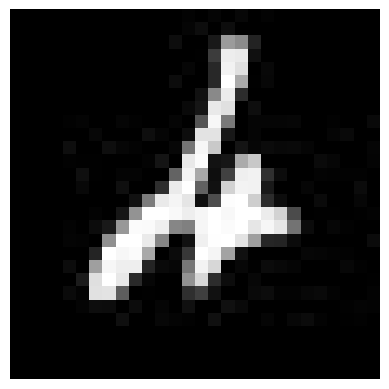

In [7]:
original_image = (loaded_sample_images[iteration].unsqueeze(0)).to(device)
z = sample_z[iteration]
with torch.no_grad():
    original_logits  = classifier(original_image.to(device))
original_class = int(torch.argmax(original_logits, 1))
plt.imshow(invTrans(loaded_sample_images[iteration]).cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [8]:
CFEs_svm = []
CFEs_st1 = []
CFEs_minchanged = []
CFEs_semifactual = []

for iteration in range(10):
    z = sample_z[iteration]
    original_image = (loaded_sample_images[iteration].unsqueeze(0)).to(device)
    
    with torch.no_grad():
        original_logits  = classifier(original_image.to(device))
        
    original_class = int(torch.argmax(original_logits, 1))
    target_class = int(torch.argsort(original_logits)[0][-2])
    
    args.class_range = f'{original_class}-{target_class}'
    direction_vector, loss_list = trainer.train_celebA_w_one(input_latent=z.unsqueeze(0), original_class=original_class, target_class=target_class, latent_shape=torch.zeros([args.latent_dim]).shape , debug_mode=debug_mode, save=False, tuned_gamma=True)
    direction_vector_norm = direction_vector / torch.linalg.norm(direction_vector)

    finder_maker = finder.FinderMaker_ImageNet_Plausible(projector=None, classifier=classifier, generator=generator, transforms=transform, args=args, gmms=trainer.gmms, center_of_target=trainer.center_of_target, SVM_coefs=None) 
    SVM_coefs = finder_maker.SVM_coefs

    z_direction, z_semifactual = finder_maker.direction_maker(z, original_class, target_class, coef_name='one', direction=direction_vector_norm)#, target_range=class_label_dict)
    z_svm = finder_maker.SVM_maker(z, original_class, target_class)#, target_range=class_label_dict)
    z_finder = finder_maker.finder_maker_one(z, original_class, target_class, direction=direction_vector_norm, mode='one')#, target_range=class_label_dict)
    
    CFEs_svm.append(z_svm)
    CFEs_st1.append(z_finder)
    CFEs_minchanged.append(z_direction)
    CFEs_semifactual.append(z_semifactual)
    
    

total_loss:0.3048, cf:0.0000, direction_norm:150.0439, 15.5020: 100%|██████████| 300/300 [00:05<00:00, 55.39it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.3599, cf:0.2764, direction_norm:37.1864, 4.6472:   2%|▏         | 6/300 [00:00<00:05, 53.59it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.3170, cf:0.0000, direction_norm:151.9887, 16.5176: 100%|██████████| 300/300 [00:05<00:00, 52.45it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:17.2789, cf:17.1748, direction_norm:37.4746, 6.6828:   2%|▏         | 5/300 [00:00<00:06, 47.93it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.3439, cf:0.0000, direction_norm:167.0825, 17.7021: 100%|██████████| 300/300 [00:05<00:00, 50.70it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:1.3549, cf:1.2475, direction_norm:42.8612, 6.4667:   0%|          | 0/300 [00:00<?, ?it/s]

svm
success. founded at negative point
finder
sucess. found at PP


total_loss:0.3325, cf:0.0000, direction_norm:162.4182, 17.0234: 100%|██████████| 300/300 [00:06<00:00, 48.59it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

svm
sucess. found at PP
finder


modifying trial:   7%|▋         | 1/15 [00:00<00:05,  2.47it/s]
total_loss:0.0854, cf:0.0000, direction_norm:37.8171, 4.8110:   2%|▏         | 6/300 [00:00<00:05, 51.77it/s]

success. founded at positive point


total_loss:0.3491, cf:0.0000, direction_norm:171.5392, 17.7743: 100%|██████████| 300/300 [00:05<00:00, 52.28it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.0846, cf:0.0000, direction_norm:37.7680, 4.7178:   2%|▏         | 6/300 [00:00<00:04, 59.02it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.3322, cf:0.0000, direction_norm:163.1158, 16.9302: 100%|██████████| 300/300 [00:05<00:00, 55.11it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.0719, cf:0.0000, direction_norm:29.7074, 4.0651:   2%|▏         | 5/300 [00:00<00:06, 46.94it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.3159, cf:0.0000, direction_norm:157.2955, 15.8816: 100%|██████████| 300/300 [00:05<00:00, 53.38it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.0883, cf:0.0000, direction_norm:36.2358, 5.0437:   2%|▏         | 5/300 [00:00<00:07, 41.12it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.2150, cf:0.0000, direction_norm:99.6641, 11.5557: 100%|██████████| 300/300 [00:05<00:00, 53.56it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.0702, cf:0.0000, direction_norm:29.2304, 3.9402:   2%|▏         | 6/300 [00:00<00:05, 57.52it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.2854, cf:0.0000, direction_norm:140.6010, 14.5075: 100%|██████████| 300/300 [00:05<00:00, 55.17it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]
total_loss:0.0999, cf:0.0000, direction_norm:39.9532, 6.0053:   2%|▏         | 5/300 [00:00<00:06, 44.97it/s]

svm
sucess. found at PP
finder
sucess. found at PP


total_loss:0.3460, cf:0.0000, direction_norm:167.8226, 17.8391: 100%|██████████| 300/300 [00:05<00:00, 51.54it/s]
modifying trial:   0%|          | 0/15 [00:00<?, ?it/s]

svm
sucess. found at PP
finder
sucess. found at PP


=====Result of CFEs generated by st.1 method=====


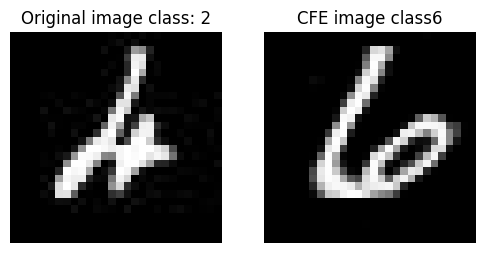

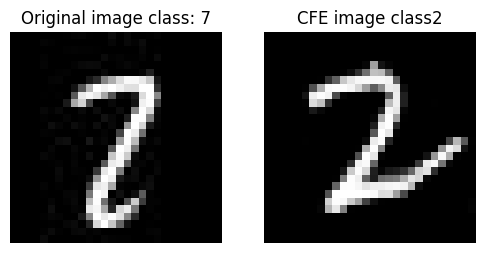

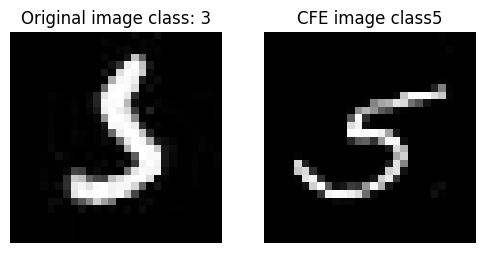

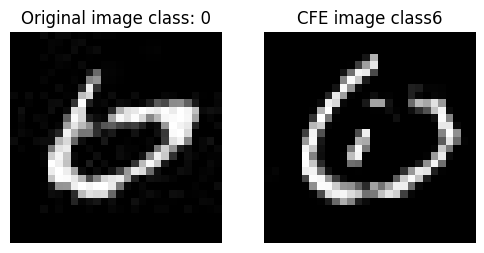

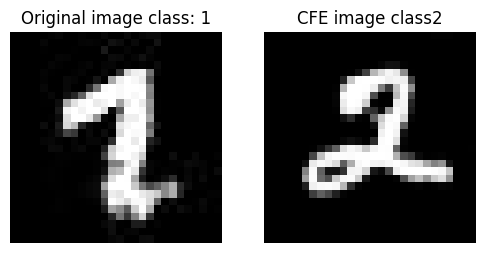

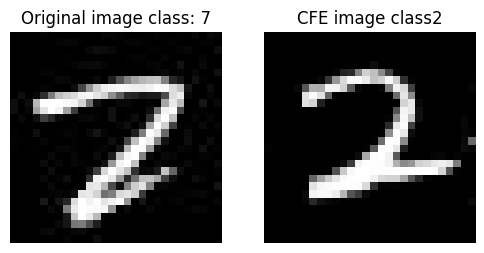

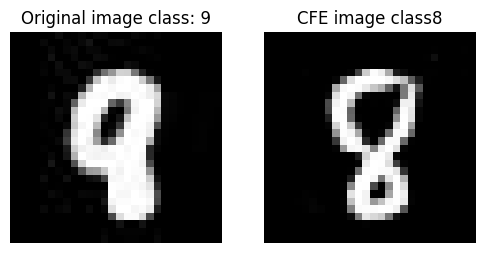

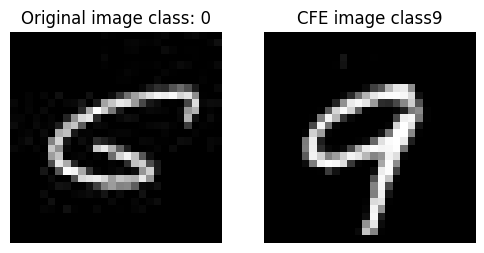

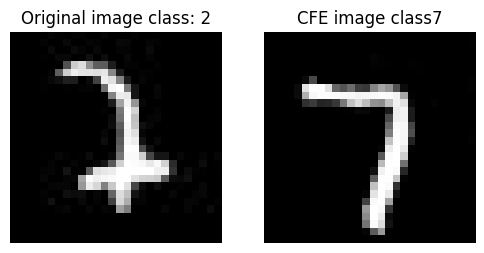

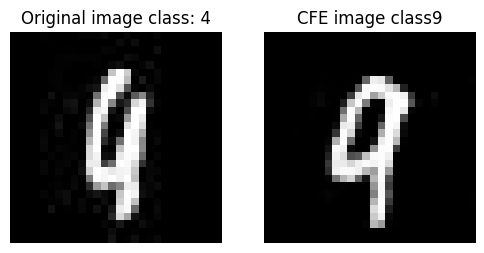

In [9]:
print("=====Result of CFEs generated by st.1 method=====")

for iteration in range(10):
    temp_original_image = loaded_sample_images[iteration]
    with torch.no_grad():
        temp_CF_image = invTrans(generator(CFEs_st1[iteration].float()))[0]
    
    original_class = int(torch.argmax(classifier(temp_original_image.unsqueeze(0))))
    counter_class = int(torch.argmax(classifier(transform(temp_CF_image).unsqueeze(0))))

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(temp_original_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Original image class: {original_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(temp_CF_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"CFE image class{counter_class}")
    plt.axis('off')

    plt.show()

=====Result of CFEs generated by SVM method=====


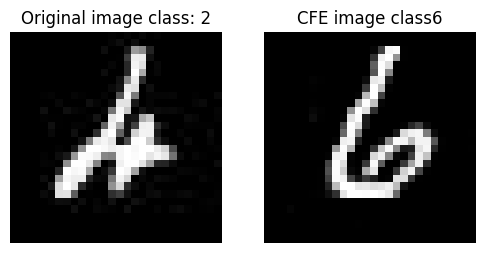

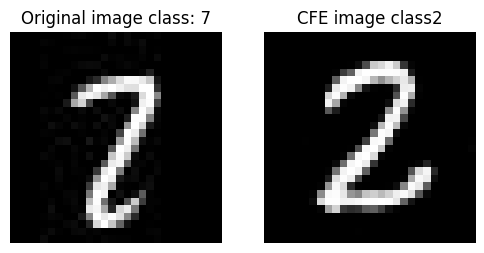

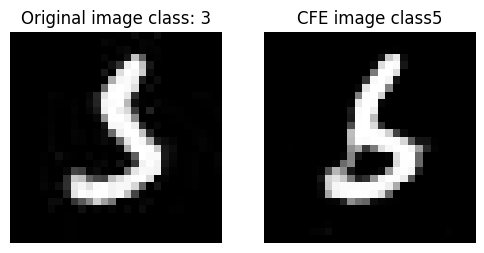

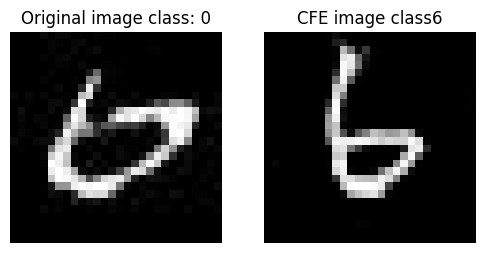

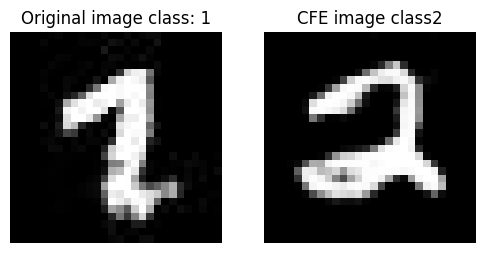

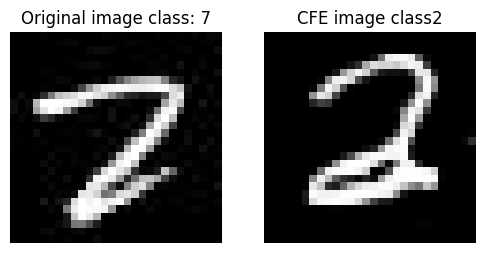

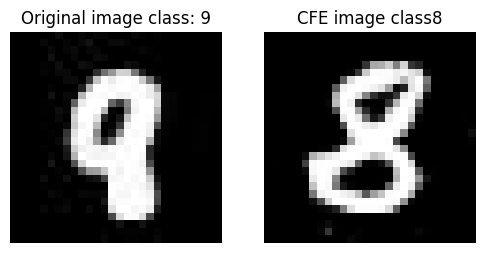

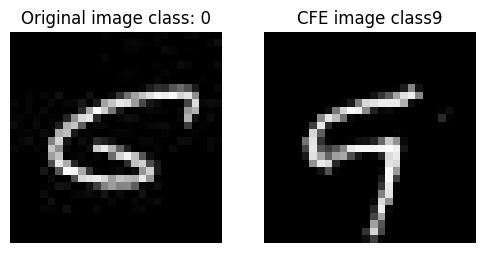

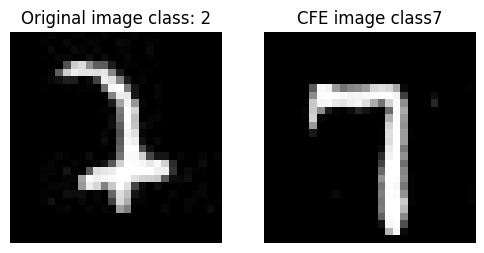

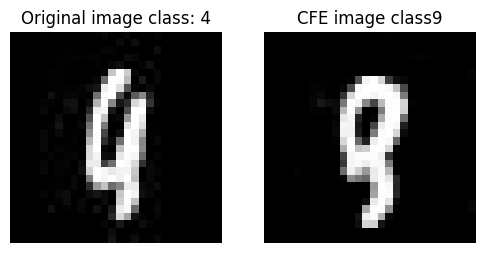

In [10]:
print("=====Result of CFEs generated by SVM method=====")

for iteration in range(10):
    temp_original_image = loaded_sample_images[iteration]
    with torch.no_grad():
        temp_CF_image = invTrans(generator(CFEs_svm[iteration].float()))[0]
    
    original_class = int(torch.argmax(classifier(temp_original_image.unsqueeze(0))))
    counter_class = int(torch.argmax(classifier(transform(temp_CF_image).unsqueeze(0))))

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(temp_original_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Original image class: {original_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(temp_CF_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"CFE image class{counter_class}")
    plt.axis('off')

    plt.show()

=====Result of CFEs generated by min_changed method=====


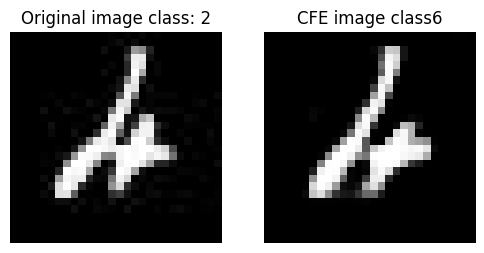

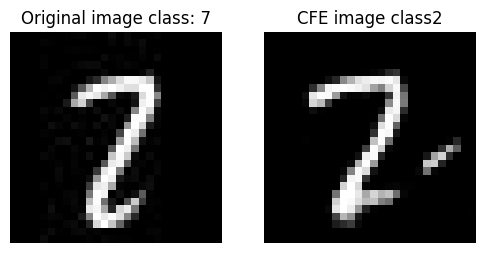

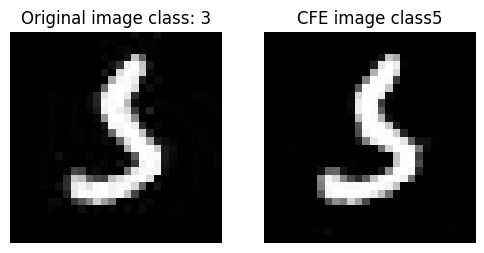

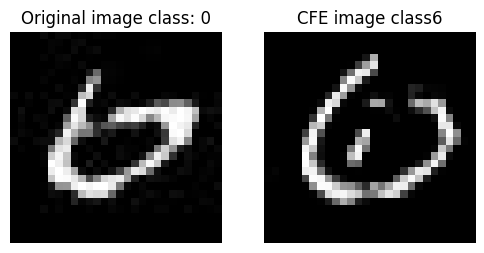

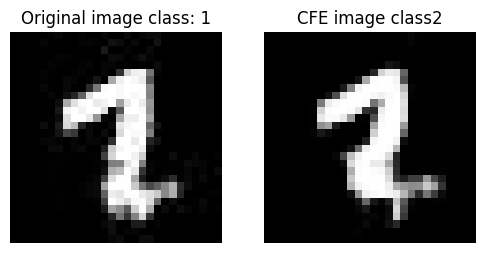

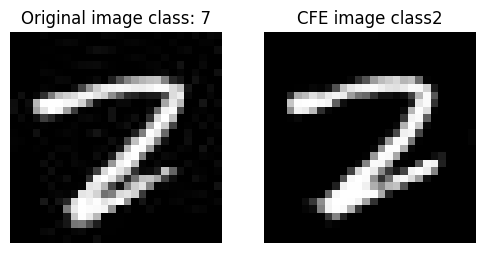

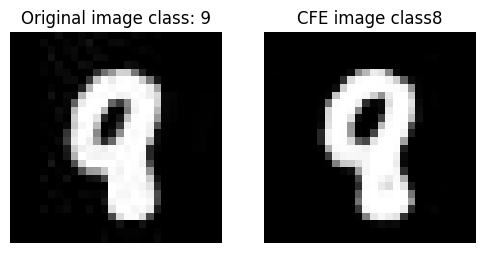

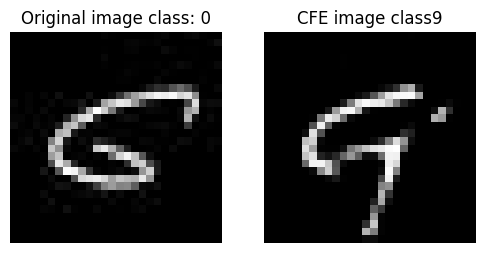

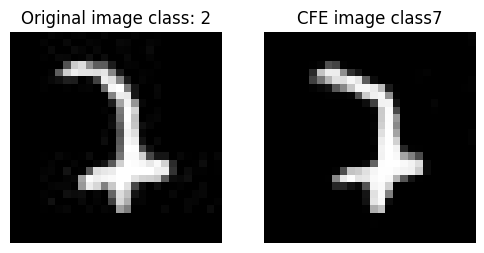

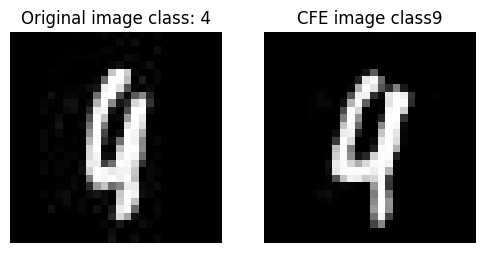

In [11]:
print("=====Result of CFEs generated by min_changed method=====")

for iteration in range(10):
    temp_original_image = loaded_sample_images[iteration]
    with torch.no_grad():
        temp_CF_image = invTrans(generator(CFEs_minchanged[iteration].float()))[0]
    
    original_class = int(torch.argmax(classifier(temp_original_image.unsqueeze(0))))
    counter_class = int(torch.argmax(classifier(transform(temp_CF_image).unsqueeze(0))))

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(temp_original_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Original image class: {original_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(temp_CF_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"CFE image class{counter_class}")
    plt.axis('off')

    plt.show()

=====Result of CFEs generated by semi_factual method=====


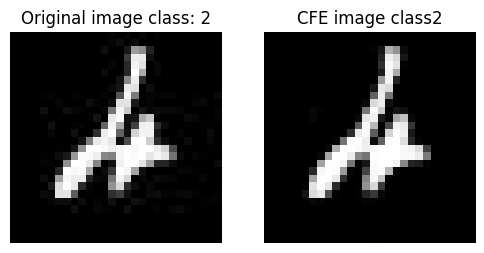

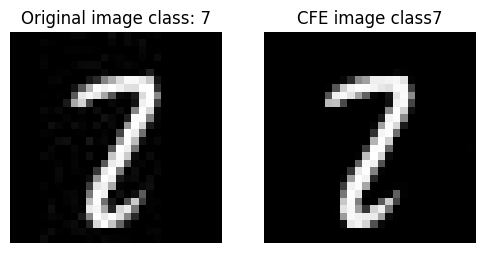

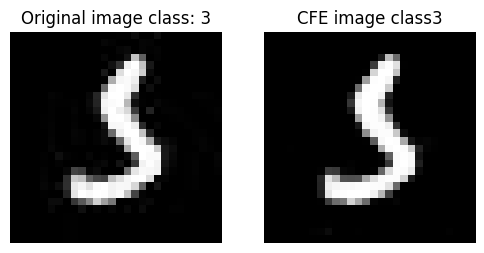

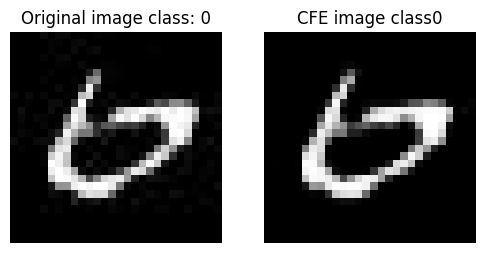

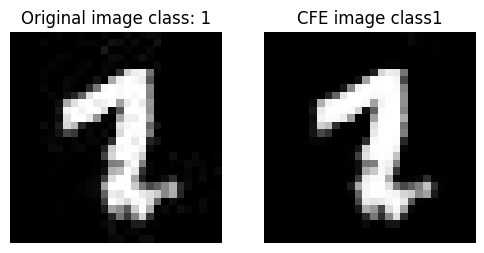

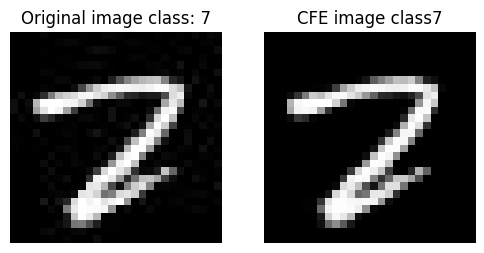

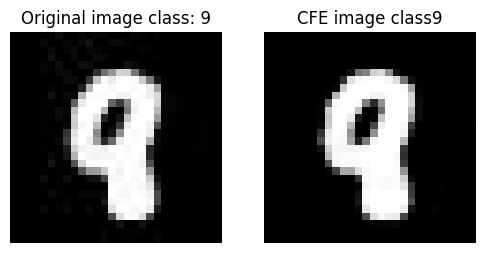

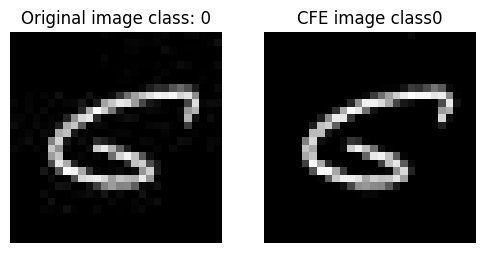

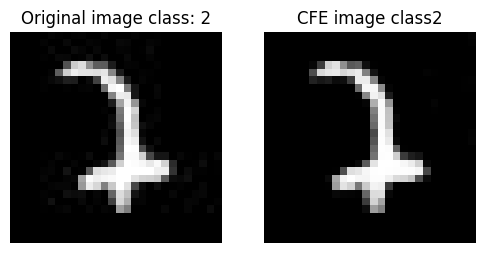

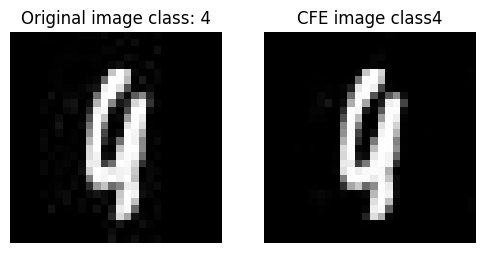

In [12]:
print("=====Result of CFEs generated by semi_factual method=====")

for iteration in range(10):
    temp_original_image = loaded_sample_images[iteration]
    with torch.no_grad():
        temp_CF_image = invTrans(generator(CFEs_semifactual[iteration].float()))[0]
    
    original_class = int(torch.argmax(classifier(temp_original_image.unsqueeze(0))))
    counter_class = int(torch.argmax(classifier(transform(temp_CF_image).unsqueeze(0))))

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(temp_original_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Original image class: {original_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(temp_CF_image.detach().cpu().squeeze(), cmap='gray')
    plt.title(f"CFE image class{counter_class}")
    plt.axis('off')

    plt.show()